직선의 방정식 
<br> 2개의 알려진 지점을 포함하는 직선의 방정식
<br> 직선 방정식 솔루션
<br> 작선에 대한 점의 위치
<br> 두 개의 다른 점으로 형성된 선에서 점의 수직 거리
<br> 선의 기울기

### 1. 기본 정의

In [1]:
import cv2 as cv
import numpy as np
import math

from matplotlib import image as img
from matplotlib import pyplot as plt

In [2]:
# QR 방향
QR_UP = "위쪽"
QR_RIGHT = "오른쪽"
QR_DOWN = "아래쪽"
QR_LEFT = "왼쪽"

### 2. 두 점 사이의 거리 (position pattern 2개따리)

In [3]:
def cv_distance(P, Q):
    # 제곱근 구하는..
    sqrt = np.sqrt((P[0] - Q[0])**2 + (P[1] - Q[1])**2)

    return sqrt

### 3. 선분과 점 사이 거리

선분과 점 사이 거리 계산을 위한 직선의 방정식
<br> https://en.wikipedia.org/wiki/Linear_equation

<br><br> 점과 직선 사이의 거리
<br> https://mathbang.net/453#gsc.tab=0

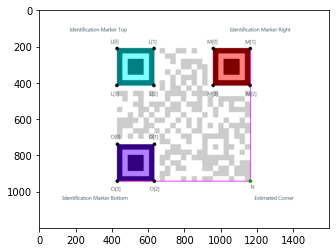

In [4]:
understand_img = img.imread('qr_understand_img.png')

plt.imshow(understand_img)
plt.show()

In [5]:
# 선분 LM 기준 점 J에서 수직으로 떨어진 거리를 계산하는 일차방정식
def cv_lineEquation(L, M, J):
    # 직선의 방정식
    a = -(M[1] - L[1]) / (M[0] - L[0])  # ax+b = 0일 때
    b = 1.0
    c = ((M[1] - L[1]) / M[0] - L[0])   # ax+by+c = 0일 때

    pdist = (a * J[0] + (b * J[1]) + c) / np.sqrt(a*a + b*b)

    return pdist

### 4. 두 점으로 이루어진 선의 기울기

선의 기울기
<br> https://www.purplemath.com/modules/slope.htm

In [6]:
def cv_lineSlope(L, M):
    dx = M[0] - L[0]
    dy = M[1] - L[1]

    if dy != 0: # 기울기 dy/dx 계산 가능해져
        alignment = 1
        return dy / dx, alignment
    
    else:   # 기울기가 그냥 0이 되어버려,,
        alignment = 0
        return 0.0, alignment

### 5. QR code 3개의 Position Pattern으로 방향 결정
<br> 위쪽(UP), 오른쪽(RIGHT), 아래쪽(DOWN), 왼쪽(LEFT)

In [7]:
def find_qr_orientation(contours, mc):
    # orientation : 방향
    # mc : QR code position pattern의 중심점 좌표 list ; (x, y)
    AB = cv_distance(mc[0], mc[1])
    BC = cv_distance(mc[1], mc[2])
    CA = cv_distance(mc[2], mc[0])

    if AB > BC and AB > CA:
        outlier = 2
        median1 = 0
        median2 = 1

    elif CA > AB and CA > BC:
        outlier = 1
        median1 = 0
        median2 = 2
    
    else:
        outlier = 0
        median1 = 1
        median2 = 2
    
    dist = cv_lineEquation(mc[median1], mc[median2], mc[outlier])
    slope, align = cv_lineSlope(mc[median1], mc[median2])

    # 방향이 UP(0)
    if align == 0:
        bottom = median1
        right = median2
        orientation = QR_UP
    
    elif slope < 0 and dist < 0:
        bottom = median1
        right = median2
        orientation = QR_UP
    
    # 방향이 RIGHT(1)
    elif slope > 0 and dist < 0:
        bottom = median2
        right = median1
        orientation = QR_RIGHT
    
    # 방향이 DOWN(2)
    elif slope < 0 and dist > 0:
        bottom = median2
        right = median1
        orientation = QR_DOWN
    
    # 방향이 LEFT(3)
    elif slope > 0 and dist > 0:
        bottom = median1
        right = median2
        orientation = QR_LEFT
    
    return outlier, bottom, right, orientation

### 6. Image Calibration 및 기울기 판단

In [8]:
def qr_calibration(image, mc):
    # QR 코드 위치 패턴 좌표 (3개의 위치 패턴)
    src_pts = np.array([mc[0], mc[1], mc[2]], dtype="float32")
    
    # 캘리브레이션 후 사용할 기준 좌표 (이론적으로 QR 코드의 위치가 정확히 정사각형일 때 좌표)
    dst_pts = np.array([
        [0, 0],         # 왼쪽 위
        [image.shape[1], 0],  # 오른쪽 위
        [image.shape[1], image.shape[0]]  # 오른쪽 아래
    ], dtype="float32")

    # 원근 변환 행렬 계산
    M = cv.getAffineTransform(src_pts, dst_pts)

    # 변환을 적용하여 이미지를 캘리브레이션
    calibrated_image = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return calibrated_image

In [9]:
# 회전 각도를 계산하는 함수
def calculate_rotation_angle(slope):
    # 아크탄젠트를 사용해 기울기에서 각도 계산
    angle = np.degrees(np.arctan(slope))
    return angle

### 7. QR code 3개의 Position Pattern detection 및 방향 계산

In [10]:
def detect_qr(image):
    # 간단한 이미지 전처리
    # GrayScale
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # img bin
    _, img_bin = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Canny Edge Detection
    img_canny = cv.Canny(img_bin, 100, 200)

    # 윤곽선 찾기
    # contour에서 3개의 position pattern 탐지 !!
    contours, hierarchy = cv.findContours(img_canny, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    mark = 0
    A, B, C = None, None, None
    
    for i in range(len(contours)):
        k = i
        c = 0

        while hierarchy[0][k][2] != -1:
            k = hierarchy[0][k][2]
            c += 1
        
        if hierarchy[0][k][2] != -1:
            c += 1
        
        if c >= 5:
            if mark == 0:
                A = i
            elif mark == 1:
                B = i
            elif mark == 2:
                C = i
            
            mark += 1
    
    # QR code position pattern 3개를 찾았을 때
    if mark >= 3:
        mu = [cv.moments(contours[A]), cv.moments(contours[B]), cv.moments(contours[C])]

        mc = [(
            mu[i]["m10"] / mu[i]["m00"],
            mu[i]["m01"] / mu[i]["m00"]
        ) for i in range(3)]

        outlier, bottom, right, orientation = find_qr_orientation(contours, mc)

        print(f"QR code 방향 : {orientation}")
        print(f"Top : {outlier}, Bottom : {bottom}, Right : {right}")

        # 외곽선 그리기
        cv.drawContours(image, contours, A, (0, 255, 0), 2)
        cv.drawContours(image, contours, B, (255, 0, 0), 2)
        cv.drawContours(image, contours, C, (0, 0, 255), 2)

        return image

    return None

### 실시간 카메라 스트리밍 및 QR detection

In [11]:
def realtime_qr_detection():
    cap = cv.VideoCapture(0)    # 0 : webcam

    if not cap.isOpened():
        print("카메라를 열 수 없습니다.")
        return
    
    while True:
        ret, frame = cap.read()

        if not ret:
            print("카메라에서 영상을 읽을 수 없습니다.")
            break

        # QR code detection 및 방향 표시
        processed_frame = detect_qr(frame)

        if processed_frame is not None:
            cv.imshow('QR code Detection', processed_frame)
        
        else:
            cv.imshow('QR code Detection', frame)
        
        # 'q' 키 누르면 종료
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv.destroyAllWindows()

In [12]:
if __name__ == "__main__":
    realtime_qr_detection()

2024-10-15 16:15:49.570 python[96085:621330] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 2, Bottom : 1, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2, Right : 0
QR code 방향 : 1
Top : 1, Bottom : 2